# Classification problem
### Considering binary and multiclasses based on brain development
(0) 4-7 years (Preschool Age), 7-9 years (School Age), 9-11 years (Pre-adolescence)

(1) 11-14 years (Early Adolescence), 15-17 years(Middle Adolescence),18-21 years (Late Adolescence)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
df = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/corr_matrices.csv',index_col=['Institution','Subject','Run'])
phenotypic = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/phenotypic.csv',index_col=['Institution','Subject'])

In [3]:
phenotypic['Age'] = phenotypic.apply(lambda row: 0 if row['Age'] > 4 and row['Age'] < 11 else 1, axis=1)

In [4]:
(phenotypic.Age).value_counts()

1    438
0    338
Name: Age, dtype: int64

In [5]:
df = df.join(pd.DataFrame(phenotypic.Age), how='left')

In [6]:
df = ((df.reset_index()).drop(columns=['Institution', 'Subject', 'Run'])).dropna()

## 2. Starting modelling

### 2.1 Logistic Regression

In [8]:
from sklearn.model_selection import train_test_split

X = df.iloc[:,:-1]
y = df.Age

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 10)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, clf.predict(X_train))))
print('Logistic Regression accuracy score in test set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(logreg, X_test, y_test, cv=5,scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

f1_scores = cross_val_score(logreg, X, y, cv=5, scoring='f1_macro')
precision_scores = cross_val_score(logreg, X, y, cv=5, scoring='precision_macro')
recall_scores = cross_val_score(logreg, X, y, cv=5, scoring='recall_macro')

print("F1_scores {} accuracy with a standard deviation of {}".format(f1_scores.mean(), f1_scores.std()))
print("Precision_scores {} accuracy with a standard deviation of {}".(precision_scores.mean(), precision_scores.std()))
print("Recall_scores {} accuracy with a standard deviation of {}".(recall_scores.mean(), recall_scores.std()))

#print(f1_score(y_test, y_pred, average="macro"))
#print(precision_score(y_test, y_pred, average="macro"))
#print(recall_score(y_test, y_pred, average="macro"))    

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_score = logreg.predict_proba(X_test)

y_score = y_score[:,1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

### 2.2 SVM

In [ ]:
from sklearn.svm import SVC
clf = SVC(kernel='linear', gamma='auto', probability=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Logistic Regression accuracy score in training set: {0:0.4f}'. format(accuracy_score(y_train, clf.predict(X_train))))
print('Logistic Regression accuracy score in test set: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

In [ ]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(clf, X, y, cv=5,scoring='accuracy')
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(dpi=100)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16}, fmt='g')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

y_score = clf.predict_proba(X_test)

y_score = y_score[:,1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

### 2.3 XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree

#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train , y_train)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
test_predictions = clf0.predict(X_test)
unseen_predictions = clf0.predict(df_test.iloc[:,1:])

#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)
cfm_unseen = confusion_matrix(df_test.iloc[:,:1], unseen_predictions)

#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)
accs_unseen = accuracy_score(df_test.iloc[:,:1], unseen_predictions)

#F1 scores for each train/test label
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
f1s_unseen_p1 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=1)
f1s_unseen_p0 = f1_score(df_test.iloc[:,:1], unseen_predictions, pos_label=0)

#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])
unseen_ras = roc_auc_score(df_test.iloc[:,:1], clf0.predict_proba(df_test.iloc[:,1:])[:,1])

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'cfm_unseen': cfm_unseen,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'unseen_accuracy': accs_unseen,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         'unseen F1-score label 1': f1s_unseen_p1,
                         'unseen F1-score label 0': f1s_unseen_p0,
                         'test roc auc score': test_ras,
                         'unseen roc auc score': unseen_ras,
                         'best_params': bp}

### PCA + pycaret

In [28]:
from sklearn.decomposition import PCA


# PCA
pca = PCA(n_components=100)
XPCA = pca.fit_transform(X.iloc[:,:])

In [29]:
XPCA.shape

(2366, 100)

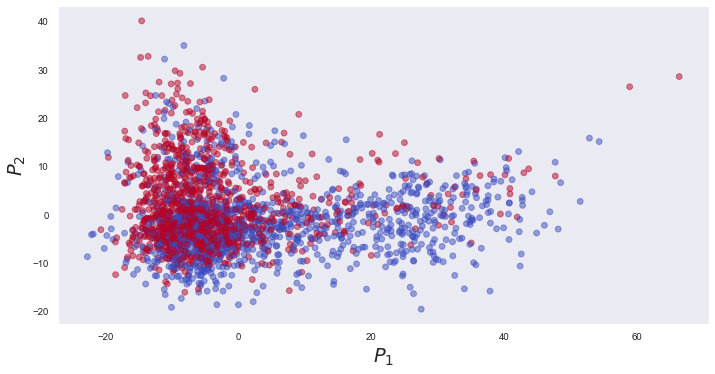

In [30]:
# Plot first and second principal component.
plt.figure(figsize=(12,6),dpi=70)
plt.scatter(XPCA[:,0], XPCA[:,1], c=df.Age.values, alpha=0.5)#,edgecolors='black', linewidth=.5, s=50)
plt.ylabel(r'$P_2$')
plt.xlabel(r'$P_1$')
plt.grid()
plt.show()

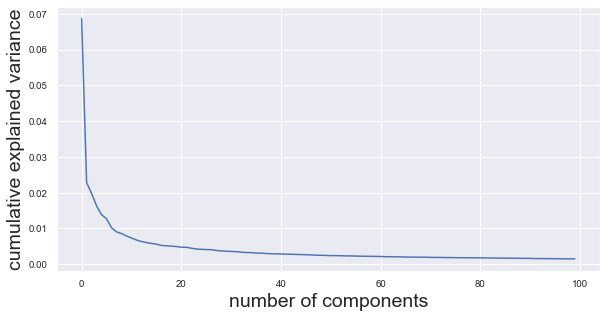

In [31]:
plt.figure(figsize=(10,5), dpi=70)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');


In [32]:
df_pca = pd.DataFrame(XPCA)
df_pca['Age'] = df.Age
df_pca = df_pca.dropna()

In [33]:
# init setup
from pycaret.classification import *
s = setup(data = df_pca, target = 'Age', session_id=123,imputation_type='iterative')

,Description,Value
0,session_id,123
1,Target,Age
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(2346, 101)"
5,Missing Values,False
6,Numeric Features,100
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [34]:
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7941,0.8761,0.8145,0.7880,0.7998,0.5880,0.5903,0.0600
lightgbm,Light Gradient Boosting Machine,0.7893,0.8662,0.8072,0.7837,0.7945,0.5784,0.5798,0.1220
xgboost,Extreme Gradient Boosting,0.7868,0.8611,0.8169,0.7760,0.7950,0.5733,0.5757,0.4050
rf,Random Forest Classifier,0.7728,0.8479,0.7735,0.7781,0.7746,0.5456,0.5472,0.1420
gbc,Gradient Boosting Classifier,0.7296,0.8050,0.7602,0.7221,0.7391,0.4588,0.4619,0.6280
qda,Quadratic Discriminant Analysis,0.7241,0.8214,0.8614,0.6801,0.7595,0.4465,0.4651,0.0070
knn,K Neighbors Classifier,0.7010,0.7631,0.8096,0.6701,0.7328,0.4004,0.4100,0.0180
ridge,Ridge Classifier,0.6991,0.0000,0.7518,0.6854,0.7161,0.3976,0.4007,0.0040
lda,Linear Discriminant Analysis,0.6991,0.7607,0.7518,0.6854,0.7161,0.3976,0.4007,0.0080
lr,Logistic Regression,0.6894,0.7557,0.7289,0.6809,0.7029,0.3783,0.3808,0.0070


In [35]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…